In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
import re
plt.style.use('ggplot')

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, BatchNormalization, Dropout, LSTM, Embedding, GlobalMaxPool1D
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#read data from csv file to pandas dataframe
df = pd.read_csv('Lyrics-Genre-Train.csv')
df2 = pd.read_csv('Lyrics-Genre-Test-GroundTruth.csv')

In [4]:
df.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260


In [5]:
df.shape

(18513, 6)

In [6]:
#put relevant data into another dataframe
data = pd.DataFrame(columns=['Genre'])
data['Genre'] = df['Genre']
data['Lyrics'] = df['Lyrics']
data.head()

,Genre,Lyrics
0,Metal,"I am a night in to the darkness, only soul los..."
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ..."
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...
3,Hip-Hop,You know what? I'm destined to be the last man...
4,Country,There ain't nothing that I would rather see\nT...


In [7]:
test = pd.DataFrame(columns=['Genre'])
test['Genre'] = df2['Genre']
test['Lyrics'] = df2['Lyrics']

In [8]:
data['label'] = 0
for index, row in data.iterrows():
    data.loc[(data['Genre'] == 'Country'), 'label'] = 0
    data.loc[(data['Genre'] == 'Electronic'), 'label'] = 1
    data.loc[(data['Genre'] == 'Folk'), 'label'] = 2
    data.loc[(data['Genre'] == 'Hip-Hop'), 'label'] = 3
    data.loc[(data['Genre'] == 'Indie'), 'label'] = 4
    data.loc[(data['Genre'] == 'Jazz'), 'label'] = 5
    data.loc[(data['Genre'] == 'Metal'), 'label'] = 6
    data.loc[(data['Genre'] == 'Pop'), 'label'] = 7
    data.loc[(data['Genre'] == 'R&B'), 'label'] = 8
    data.loc[(data['Genre'] == 'Rock'), 'label'] = 9

In [9]:
data.head()

,Genre,Lyrics,label
0,Metal,"I am a night in to the darkness, only soul los...",6
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",3
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,6
3,Hip-Hop,You know what? I'm destined to be the last man...,3
4,Country,There ain't nothing that I would rather see\nT...,0


In [10]:
test['label'] = 0
for index, row in test.iterrows():
    test.loc[(test['Genre'] == 'Country'), 'label'] = 0
    test.loc[(test['Genre'] == 'Electronic'), 'label'] = 1
    test.loc[(test['Genre'] == 'Folk'), 'label'] = 2
    test.loc[(test['Genre'] == 'Hip-Hop'), 'label'] = 3
    test.loc[(test['Genre'] == 'Indie'), 'label'] = 4
    test.loc[(test['Genre'] == 'Jazz'), 'label'] = 5
    test.loc[(test['Genre'] == 'Metal'), 'label'] = 6
    test.loc[(test['Genre'] == 'Pop'), 'label'] = 7
    test.loc[(test['Genre'] == 'R&B'), 'label'] = 8
    test.loc[(test['Genre'] == 'Rock'), 'label'] = 9

In [11]:
test.head()

,Genre,Lyrics,label
0,Hip-Hop,Most folks spend their days daydreaming of fin...,3
1,Indie,Take your cold hands and put them on my face\n...,4
2,Metal,Are you ready it's time for war\nWe'll break d...,6
3,Pop,You ask me why I change the color of my hair\n...,7
4,Hip-Hop,Do you believe in magic in a young girl's hear...,3


In [12]:
#view class distribution
country = data[data['label']==0]
electronic = data[data['label']==1]
folk = data[data['label']==2]
hiphop = data[data['label']==3]
indie = data[data['label']==4]
jazz = data[data['label']==5]
metal = data[data['label']==6]
pop = data[data['label']==7]
rnb = data[data['label']==8]
rock = data[data['label']==9]
print(country.shape)
print(electronic.shape)
print(folk.shape)
print(hiphop.shape)
print(indie.shape)
print(jazz.shape)
print(metal.shape)
print(pop.shape)
print(rnb.shape)
print(rock.shape)




(1890, 3)
(1540, 3)
(1153, 3)
(2240, 3)
(1190, 3)
(1540, 3)
(1890, 3)
(2590, 3)
(1190, 3)
(3290, 3)


e:\nlp2\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genre', ylabel='count'>

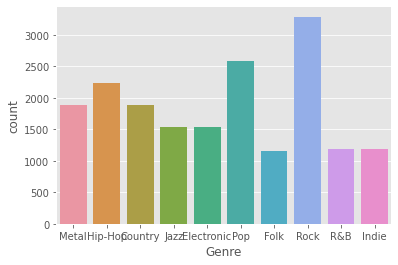

In [13]:
sns.countplot('Genre',data=data)

In [14]:
clean = []
stop_words = stopwords.words('english')
stop_words.append('chorus')
stop_words.append('verse')
lemmatizer = WordNetLemmatizer()

In [15]:
for index, row in data.iterrows():
    lyrics = row['Lyrics']
    lyrics = re.sub('\n', "", lyrics)
    lyrics = re.sub('x1', "", lyrics)
    lyrics = re.sub('x2', "", lyrics)
    lyrics = re.sub('x3', "", lyrics)
    lyrics = re.sub('x4', "", lyrics)
    lyrics = re.sub('x5', "", lyrics)
    lyrics = re.sub('x6', "", lyrics)
    lyrics = re.sub('x7', "", lyrics)
    lyrics = re.sub('x8', "", lyrics)
    lyrics = re.sub('x9', "", lyrics)
    lyrics = lyrics.lower() #lowercasing
    lyrics = re.sub("[^a-z]+", " ", lyrics) #remove all numbers and special chars
    lyrics = lyrics.split()
    lyrics = [word for word in lyrics if not word in stop_words] #remove stopwords
    lyrics = [lemmatizer.lemmatize(token) for token in lyrics] #lemmatize
    lyrics = [lemmatizer.lemmatize(token, "v") for token in lyrics]
    lyrics = " ".join(lyrics)
    clean.append(lyrics)
data['new'] = clean #add clean tweets to a new column in the dataframe


In [16]:
data.head()

,Genre,Lyrics,label,new
0,Metal,"I am a night in to the darkness, only soul los...",6,night darkness soul lose walk throught thenigh...
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",3,yeahsometimes wanna fly away say skate surf st...
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,6,work hard work hard chicago work hard try hard...
3,Hip-Hop,You know what? I'm destined to be the last man...,3,know destine last man standincarefully mappin ...
4,Country,There ain't nothing that I would rather see\nT...,0,nothing would rather seethan dry docki think g...


In [17]:
clean = []
for index, row in test.iterrows():
    lyrics = row['Lyrics']
    lyrics = re.sub('\n', "", lyrics)
    lyrics = re.sub('x1', "", lyrics)
    lyrics = re.sub('x2', "", lyrics)
    lyrics = re.sub('x3', "", lyrics)
    lyrics = re.sub('x4', "", lyrics)
    lyrics = re.sub('x5', "", lyrics)
    lyrics = re.sub('x6', "", lyrics)
    lyrics = re.sub('x7', "", lyrics)
    lyrics = re.sub('x8', "", lyrics)
    lyrics = re.sub('x9', "", lyrics)
    lyrics = lyrics.lower() #lowercasing
    lyrics = re.sub("[^a-z]+", " ", lyrics) #remove all numbers and special chars
    lyrics = lyrics.split()
    lyrics = [word for word in lyrics if not word in stop_words] #remove stopwords
    lyrics = [lemmatizer.lemmatize(token) for token in lyrics] #lemmatize
    lyrics = [lemmatizer.lemmatize(token, "v") for token in lyrics]
    lyrics = " ".join(lyrics)
    clean.append(lyrics)
test['new'] = clean #add clean tweets to a new column in the dataframe


In [18]:
test.head()

,Genre,Lyrics,label,new
0,Hip-Hop,Most folks spend their days daydreaming of fin...,3,folk spend day daydream find cluesmy whole lif...
1,Indie,Take your cold hands and put them on my face\n...,4,take cold hand put facesharpen axe criminal wa...
2,Metal,Are you ready it's time for war\nWe'll break d...,6,ready time warwe break fuck doorssmash window ...
3,Pop,You ask me why I change the color of my hair\n...,7,ask change color hair yeah ask need thirty two...
4,Hip-Hop,Do you believe in magic in a young girl's hear...,3,believe magic young girl hearthow music free w...


In [19]:
data_copy=data
data_copy.head()

,Genre,Lyrics,label,new
0,Metal,"I am a night in to the darkness, only soul los...",6,night darkness soul lose walk throught thenigh...
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",3,yeahsometimes wanna fly away say skate surf st...
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,6,work hard work hard chicago work hard try hard...
3,Hip-Hop,You know what? I'm destined to be the last man...,3,know destine last man standincarefully mappin ...
4,Country,There ain't nothing that I would rather see\nT...,0,nothing would rather seethan dry docki think g...


In [20]:
#visualise word frequency in each class
country = ' '.join(data[data.label == 0].new.values)
electronic = ' '.join(data[data.label == 1].new.values)
folk = ' '.join(data[data.label == 2].new.values)
hiphop = ' '.join(data[data.label == 3].new.values)
indie = ' '.join(data[data.label == 4].new.values)
jazz = ' '.join(data[data.label == 5].new.values)
metal = ' '.join(data[data.label == 6].new.values)
pop = ' '.join(data[data.label == 7].new.values)
randb = ' '.join(data[data.label == 8].new.values)
rock = ' '.join(data[data.label == 9].new.values)

Text(0.5, 1.0, 'Country')

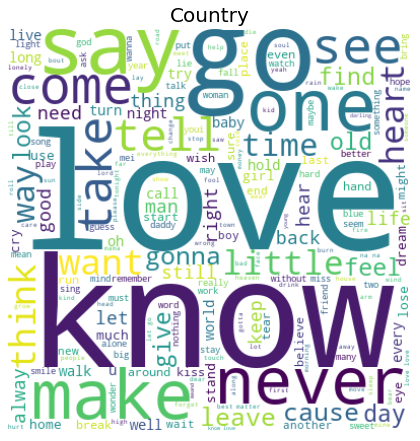

In [21]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(country)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Country', size=20)

Text(0.5, 1.0, 'Electronic')

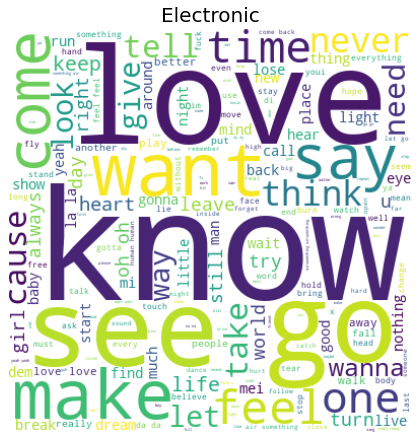

In [22]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(electronic)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Electronic', size=20)

Text(0.5, 1.0, 'Folk')

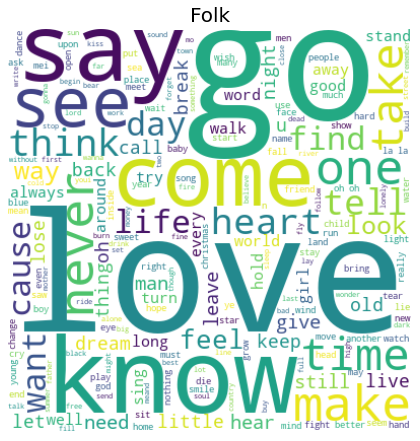

In [23]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(folk)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Folk', size=20)

Text(0.5, 1.0, 'Hip Hop')

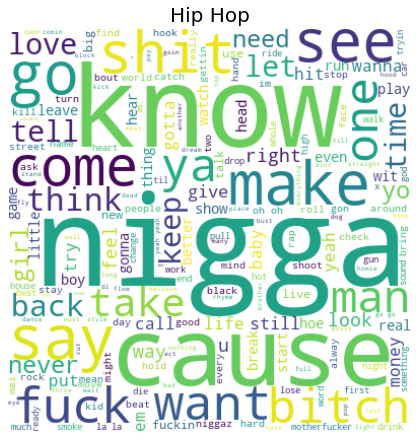

In [24]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(hiphop)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Hip Hop', size=20)

Text(0.5, 1.0, 'Indie')

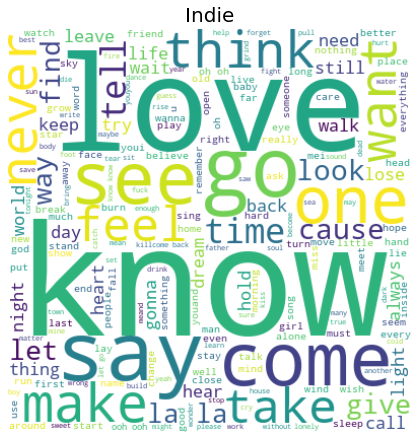

In [25]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(indie)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Indie', size=20)

Text(0.5, 1.0, 'Jazz')

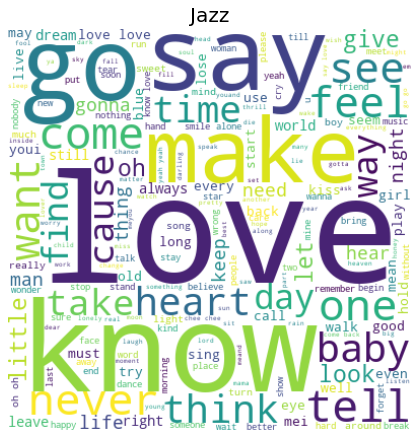

In [26]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(jazz)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Jazz', size=20)

Text(0.5, 1.0, 'Metal')

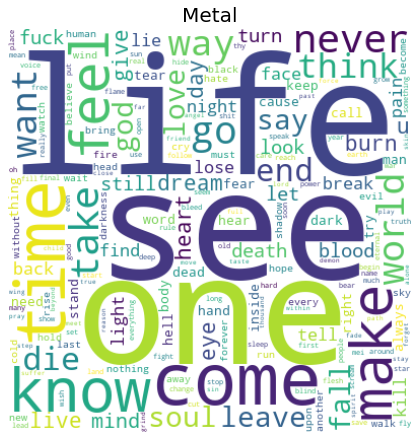

In [27]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(metal)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Metal', size=20)

Text(0.5, 1.0, 'Pop')

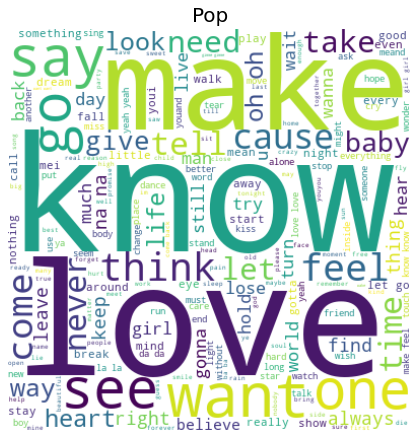

In [28]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(pop)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Pop', size=20)

Text(0.5, 1.0, 'R&B')

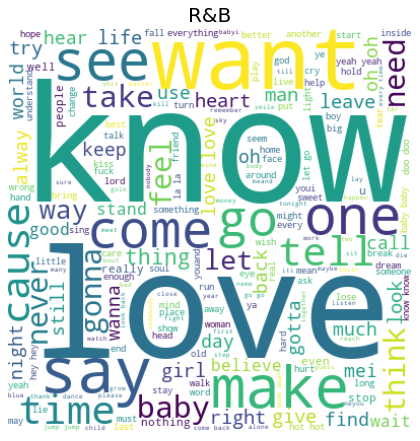

In [30]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(randb)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('R&B', size=20)

Text(0.5, 1.0, 'Rock')

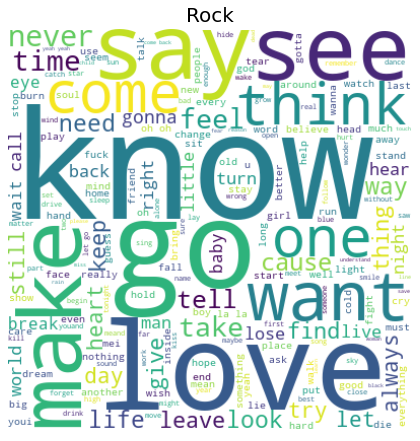

In [31]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(rock)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Rock', size=20)

In [32]:
#feature extraction
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=10)
train_data = data['new']
test_data = test['new']
all_data = train_data.append(test_data)
features = vectorizer.fit_transform(all_data).toarray()
X = features[:18513]
X_test = features[18513:]
print(features.shape)

(26448, 29016)


In [33]:
#split data
X_train, X_valid, y_train, y_valid = train_test_split(X, data.label,test_size = 0.05)

e:\nlp2\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.39740820734341253
926


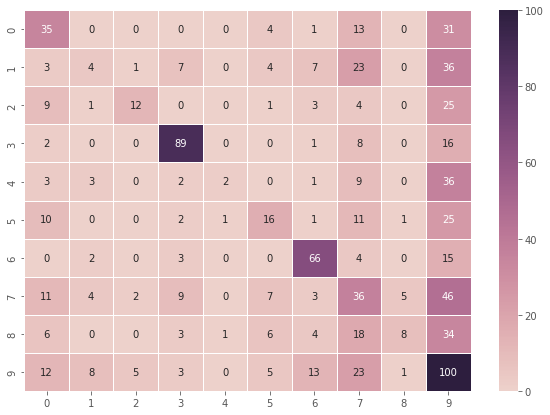

In [34]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_predicted = lr.predict(X_valid)
score = lr.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.4020163831127914
7935


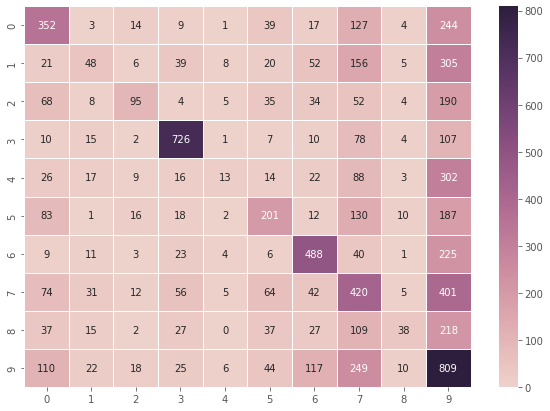

In [35]:
y_test = test.label
predicted = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.4298056155507559
926


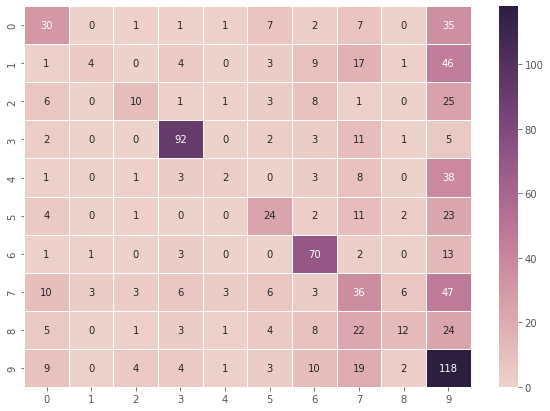

In [36]:
from sklearn.naive_bayes import BernoulliNB
brn = BernoulliNB()
brn.fit(X_train, y_train)
y_predicted = brn.predict(X_valid)
score = brn.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.41600504095778196
7935


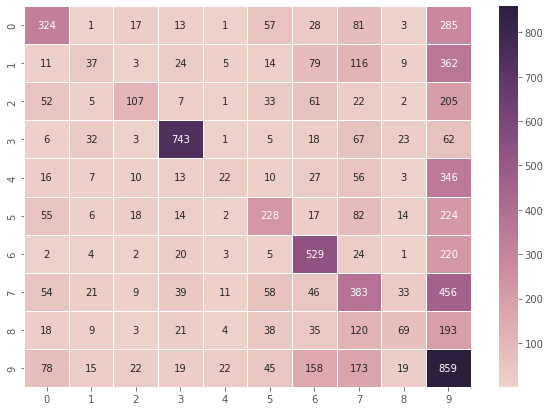

In [37]:
y_test = test.label
predicted = brn.predict(X_test)
score = brn.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.3509719222462203
926


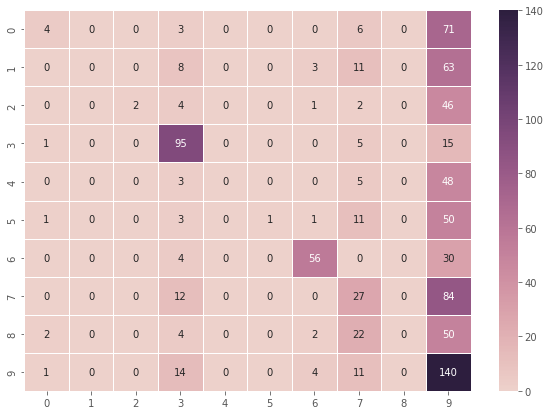

In [38]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_valid)
score = clf.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.33320730938878385
7935


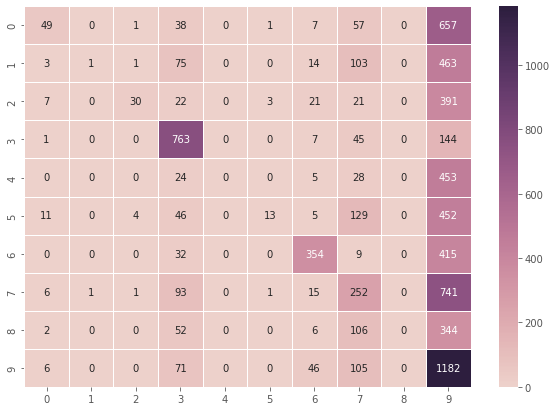

In [39]:
y_test = test.label
predicted = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.3833693304535637
926


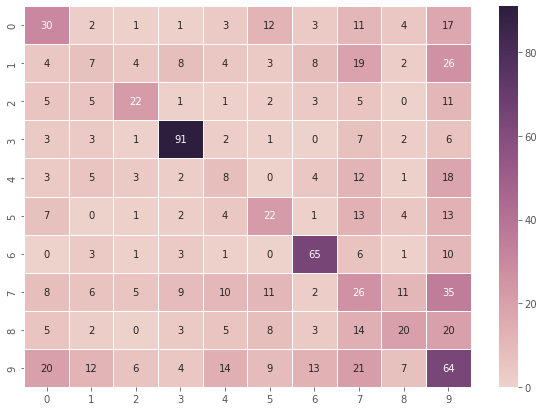

In [40]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_valid)
score = clf.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

0.37681159420289856
7935


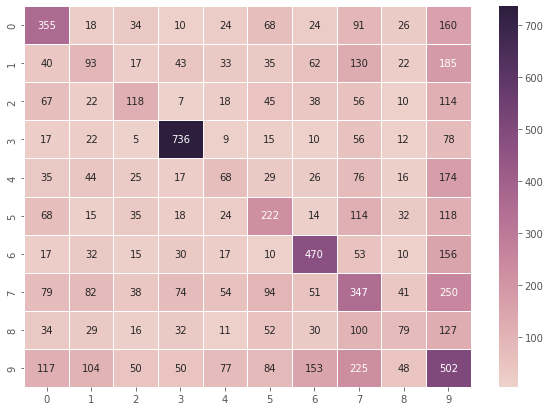

In [41]:
y_test = test.label
predicted = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [42]:
#Sequence + tokanization 
all_data = []
train_data = data['new']
test_data = test['new']
all_data = train_data.append(test_data)
y= data['label']
num_words = all_data.shape[0]
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(all_data)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(all_data)
length=[]
for i in sequences:
    length.append(len(i))
print("Max is: ",np.max(length))

Max is:  966


In [43]:
#Adding padding for Deep Learning model
sequences = pad_sequences(sequences, padding = 'post')
X = sequences[:18513]
X_test = sequences[18513:]

In [44]:
#Split the data
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.05)

In [65]:
#model
def build_model(nr_labels, length):
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length = length))
    model.add(LSTM(32, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nr_labels, activation='sigmoid'))
    return model

def build_compiled_model(length):
    model = build_model(nr_labels=10, length = length)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_compiled_model(np.max(length))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 966, 32)           846336    
                                                                 
 lstm_2 (LSTM)               (None, 966, 32)           8320      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                      

In [66]:
#train model
history = model.fit(x=x_train, y=y_train, epochs=3, validation_data=(x_valid, y_valid), shuffle=True)

Epoch 1/3
550/550 [==============================] - 17s 29ms/step - loss: 2.0862 - accuracy: 0.2527 - val_loss: 1.9863 - val_accuracy: 0.3024
Epoch 2/3
550/550 [==============================] - 15s 28ms/step - loss: 1.8238 - accuracy: 0.3551 - val_loss: 1.8737 - val_accuracy: 0.3575
Epoch 3/3
550/550 [==============================] - 15s 28ms/step - loss: 1.5935 - accuracy: 0.4361 - val_loss: 1.8939 - val_accuracy: 0.3434


In [67]:
#make predictions
y_pred = np.argmax(model.predict(x_valid), axis=1)

On validation data:
Accuracy: 0.34


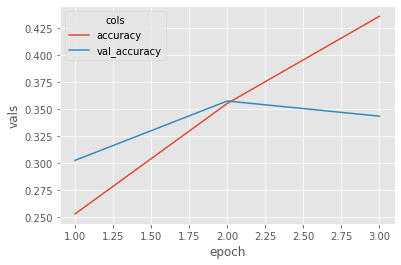

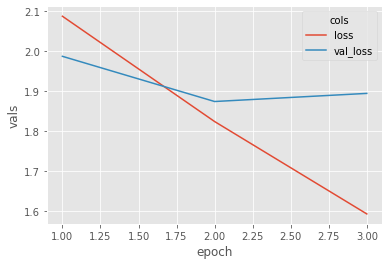

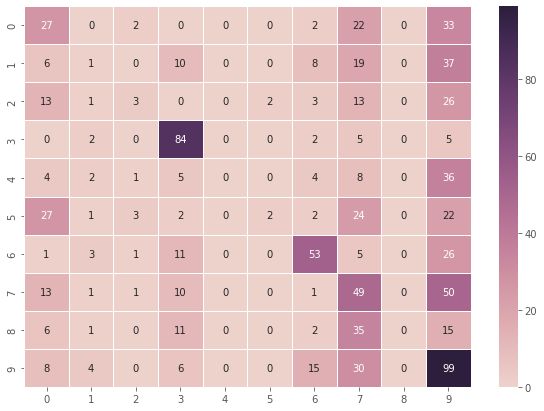

In [68]:
print('On validation data:')
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

# plot graphs
metrics_df = pd.DataFrame(history.history).reset_index().rename(columns={"index": "epoch"})
metrics_df['epoch'] = metrics_df['epoch'] + 1
acc_df = metrics_df[['epoch', 'accuracy', 'val_accuracy']].melt('epoch', var_name='cols', value_name='vals')
loss_df = metrics_df[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='cols', value_name='vals')
sns.lineplot(data=acc_df, x='epoch', y='vals', hue='cols')
plt.show()
sns.lineplot(data=loss_df, x='epoch', y='vals', hue='cols')
plt.show()

# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [69]:
#Sequence + tokanization 
y_test = test['label']

In [70]:
pred = np.argmax(model.predict(X_test), axis=1)

On test data:
Accuracy: 0.35


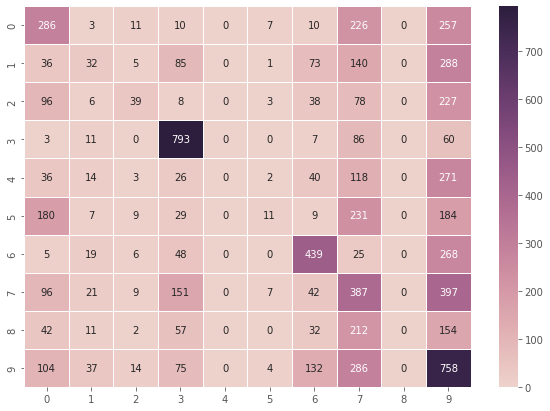

In [71]:
print('On test data:')
print('Accuracy: %.2f' % accuracy_score(y_test, pred))
# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [52]:
def build_model(nr_labels, length):
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length = length))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPool1D(5))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPool1D(5))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPool1D(5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nr_labels, activation='softmax'))

    return model

def build_compiled_model(length):
    model = build_model(nr_labels=6, length = length)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_compiled_model(np.max(length))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 966, 32)           846336    
                                                                 
 conv1d (Conv1D)             (None, 962, 128)          20608     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 192, 128)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 192, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 188, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 256)          0         
 1D)                                                  

In [53]:
#train model
history = model.fit(x=x_train, y=y_train, epochs=3, validation_data=(x_valid, y_valid), shuffle=True)

Epoch 1/5
550/550 [==============================] - 8s 12ms/step - loss: nan - accuracy: 0.1026 - val_loss: nan - val_accuracy: 0.0929
Epoch 2/5
550/550 [==============================] - 6s 11ms/step - loss: nan - accuracy: 0.1026 - val_loss: nan - val_accuracy: 0.0929
Epoch 3/5
550/550 [==============================] - 6s 11ms/step - loss: nan - accuracy: 0.1026 - val_loss: nan - val_accuracy: 0.0929
Epoch 4/5
550/550 [==============================] - 6s 11ms/step - loss: nan - accuracy: 0.1026 - val_loss: nan - val_accuracy: 0.0929
Epoch 5/5
550/550 [==============================] - 6s 11ms/step - loss: nan - accuracy: 0.1026 - val_loss: nan - val_accuracy: 0.0929


In [54]:
#make predictions
y_pred = np.argmax(model.predict(x_valid), axis=1)

On validation data:
Accuracy: 0.09


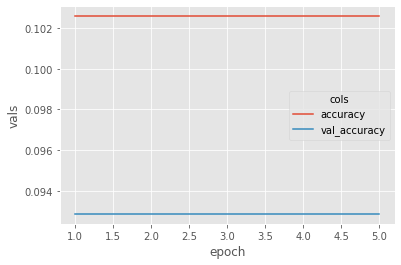

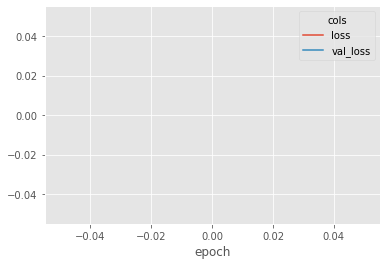

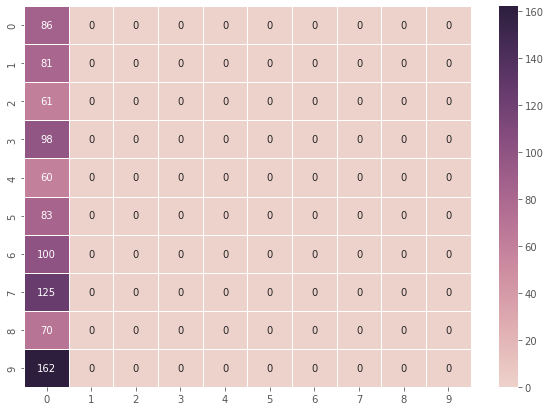

In [55]:
print('On validation data:')
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

# plot graphs
metrics_df = pd.DataFrame(history.history).reset_index().rename(columns={"index": "epoch"})
metrics_df['epoch'] = metrics_df['epoch'] + 1
acc_df = metrics_df[['epoch', 'accuracy', 'val_accuracy']].melt('epoch', var_name='cols', value_name='vals')
loss_df = metrics_df[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='cols', value_name='vals')
sns.lineplot(data=acc_df, x='epoch', y='vals', hue='cols')
plt.show()
sns.lineplot(data=loss_df, x='epoch', y='vals', hue='cols')
plt.show()

# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [56]:
pred = np.argmax(model.predict(X_test), axis=1)

On test data:
Accuracy: 0.10


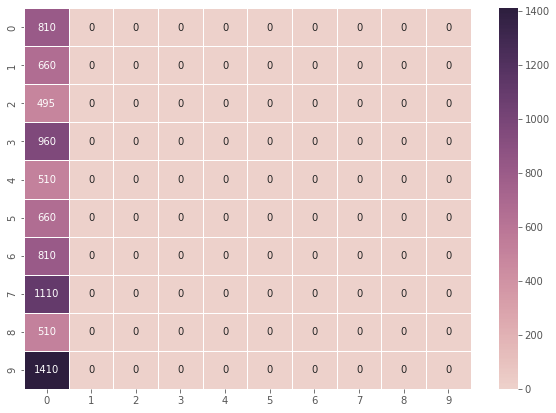

In [57]:
print('On test data:')
print('Accuracy: %.2f' % accuracy_score(y_test, pred))
# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()